# Predicting Fetal Health from Cardiotocography (CTG) Data

**Goal:** Use a Kaggle dataset of CTG measurements to predict fetal health status
(normal / suspect / pathological) and explore which features are most informative.

Main steps:
1. Load and inspect the dataset
2. Exploratory data analysis (EDA)
3. Train/test split & baseline models
4. Handle class imbalance and choose appropriate metrics
5. Train and tune a more advanced model (gradient boosting)
6. Interpret the model

Dataset: https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification

### Imports & basic configuration

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    accuracy_score, recall_score, precision_score
)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option("display.max_columns", None)

DATA_PATH = "fetal_health.csv"
TARGET_COLUMN = "fetal_health"

### Load data

In [2]:
df = pd.read_csv(DATA_PATH)

df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


### Basic inspection (info, class distribution, descriptive stats)

In [3]:
def print_basic_info(_df, target_col):
    print("Shape:", _df.shape)
    print("\nData types:")
    print(_df.dtypes)
    print("\nTarget distribution (counts):")
    print(_df[target_col].value_counts().sort_index())
    print("\nTarget distribution (normalized):")
    print(_df[target_col].value_counts(normalize=True).sort_index())

print_basic_info(df, TARGET_COLUMN)

# Basic stats for numerical features
df.describe().T

Shape: (2126, 22)

Data types:
baseline value                                            float64
accelerations                                             float64
fetal_movement                                            float64
uterine_contractions                                      float64
light_decelerations                                       float64
severe_decelerations                                      float64
prolongued_decelerations                                  float64
abnormal_short_term_variability                           float64
mean_value_of_short_term_variability                      float64
percentage_of_time_with_abnormal_long_term_variability    float64
mean_value_of_long_term_variability                       float64
histogram_width                                           float64
histogram_min                                             float64
histogram_max                                             float64
histogram_number_of_peaks                    

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


### Class distribution plot

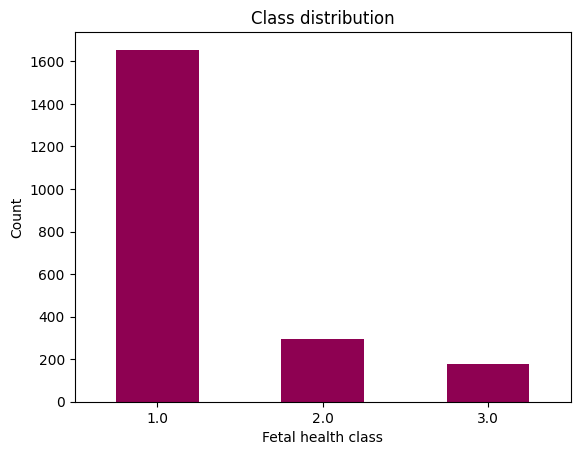

In [4]:
def plot_class_distribution(_df, target_col: str):
    counts = _df[target_col].value_counts().sort_index()
    plt.figure()
    counts.plot(kind="bar", colormap="PiYG")
    plt.xticks(rotation=0)
    plt.xlabel("Fetal health class")
    plt.ylabel("Count")
    plt.title("Class distribution")
    plt.show()

plot_class_distribution(df, TARGET_COLUMN)

### Histograms for a subset of features

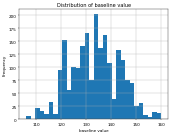

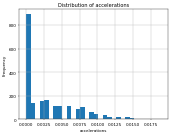

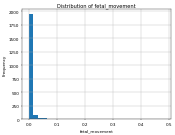

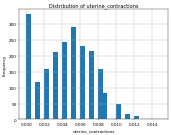

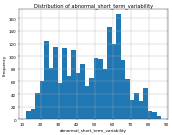

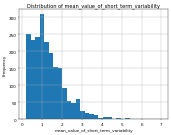

In [5]:
features_to_plot = [
    "baseline value",
    "accelerations",
    "fetal_movement",
    "uterine_contractions",
    "abnormal_short_term_variability",
    "mean_value_of_short_term_variability",
]

for col in features_to_plot:
    if col not in df.columns:
        print(f"Warning: {col} not in columns, skipping.")
        continue

    plt.figure(dpi=30)
    df[col].hist(bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

### Correlation matrix for numerical features

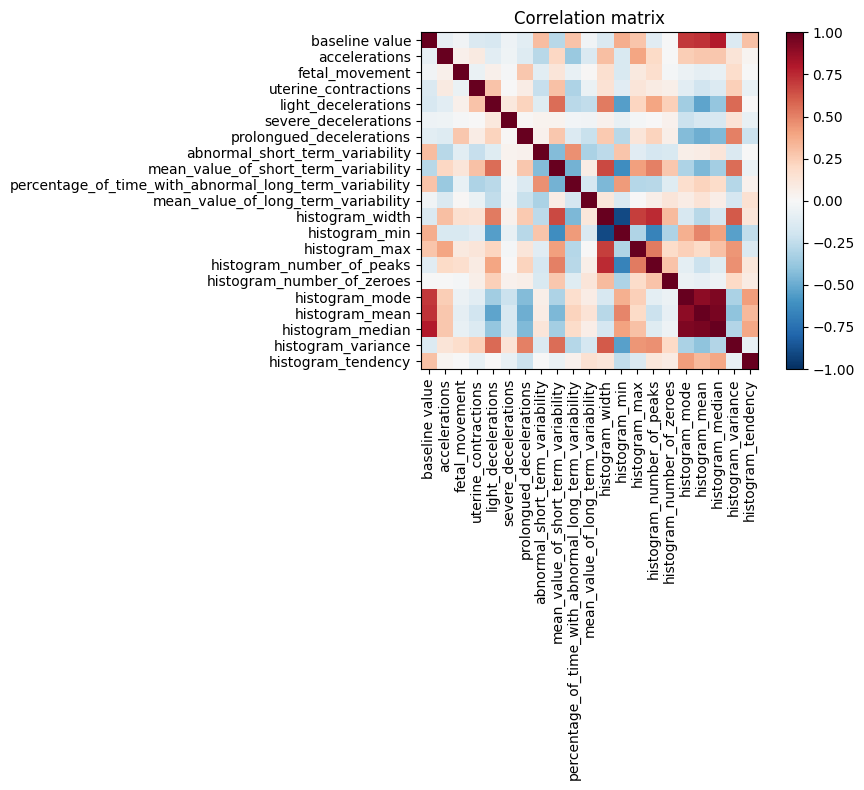

In [6]:
corr = df.drop(columns=[TARGET_COLUMN]).corr(numeric_only=True)

plt.figure(figsize=(10, 8))
im = plt.imshow(corr, cmap="RdBu_r", interpolation="nearest", norm=matplotlib.colors.Normalize(vmin=-1, vmax=1))
plt.colorbar(im)
plt.title("Correlation matrix")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

### Clustering of features

In [7]:
# Absolute correlation between features (no target)
feature_cols = [c for c in df.columns if c != TARGET_COLUMN]
corr_abs = df[feature_cols].corr().abs()

# Convert to distance matrix for clustering
# distance_ij = 1 - |corr_ij|
dist = 1 - corr_abs
# squareform wants a condensed distance matrix
dist_condensed = squareform(dist.values, checks=False)

# Hierarchical clustering
Z = linkage(dist_condensed, method="average")

# Cut the dendrogram at some distance threshold to form clusters
# Smaller t -> more clusters, larger t -> fewer clusters.
cluster_labels = fcluster(Z, t=0.4, criterion="distance")

cluster_df = pd.DataFrame(
    {"feature": feature_cols, "cluster": cluster_labels}
).sort_values("cluster")

cluster_df

,feature,cluster
0,baseline value,1
18,histogram_median,1
17,histogram_mean,1
16,histogram_mode,1
6,prolongued_decelerations,2
20,histogram_tendency,3
12,histogram_min,4
11,histogram_width,4
14,histogram_number_of_peaks,4
8,mean_value_of_short_term_variability,5


### Label encoding
Encoding classes 1/2/3 into 0/1/2 for scikit-learn models

In [8]:
X = df.drop(columns=[TARGET_COLUMN])
y_raw = df[TARGET_COLUMN]

le = LabelEncoder()
y = le.fit_transform(y_raw)

class_labels = le.classes_
print("Encoded classes (index -> label):")
for idx, cls in enumerate(class_labels):
    print(idx, "->", cls)

CLASS_NAME_MAP = {
    1: "Norm.",
    2: "Susp.",
    3: "Path.",
}

def get_pretty_labels(_le):
    return [CLASS_NAME_MAP[int(c)] for c in _le.classes_]

Encoded classes (index -> label):
0 -> 1.0
1 -> 2.0
2 -> 3.0


### Selection of representative features

In [9]:
# Approximate correlation with target (using Pearson on encoded labels)
target_corr = df[feature_cols].corrwith(y_raw)

rep_features = []

for cl in sorted(cluster_df["cluster"].unique()):
    members = cluster_df[cluster_df["cluster"] == cl]["feature"]
    # pick member with largest |corr to target|
    best_feat = target_corr.loc[members].abs().idxmax()
    rep_features.append(best_feat)

print("Representative features per cluster:")
rep_features

Representative features per cluster:


['histogram_mode',
 'prolongued_decelerations',
 'histogram_tendency',
 'histogram_width',
 'mean_value_of_short_term_variability',
 'light_decelerations',
 'histogram_variance',
 'histogram_max',
 'abnormal_short_term_variability',
 'percentage_of_time_with_abnormal_long_term_variability',
 'accelerations',
 'uterine_contractions',
 'histogram_number_of_zeroes',
 'mean_value_of_long_term_variability',
 'fetal_movement',
 'severe_decelerations']

### Train/test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))

X_rep = df[rep_features]
X_train_rep, X_test_rep, y_train_rep, y_test_rep = train_test_split(
    X_rep,
    y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("Train shape:", X_train_rep.shape, "Test shape:", X_test_rep.shape)
print("Train class distribution:")
print(pd.Series(y_train_rep).value_counts(normalize=True))

Train shape: (1700, 21) Test shape: (426, 21)
Train class distribution:
0    0.778235
1    0.138824
2    0.082941
Name: proportion, dtype: float64
Train shape: (1700, 16) Test shape: (426, 16)
Train class distribution:
0    0.778235
1    0.138824
2    0.082941
Name: proportion, dtype: float64


### Evaluation helpers

In [26]:
def evaluate_on_holdout_encoded(_m, _x_train, _y_train, _x_test, _y_test, _le, model_name="model"):
    """
    Fit model on encoded labels, decode predictions for reporting.
    """
    print(f"\n=== {model_name} ===")
    _m.fit(_x_train, _y_train)

    y_pred_enc = _m.predict(_x_test)
    y_pred = _le.inverse_transform(y_pred_enc)
    y_test_decoded = _le.inverse_transform(_y_test)

    acc = accuracy_score(y_test_decoded, y_pred)
    macro_f1 = f1_score(y_test_decoded, y_pred, average="macro")

    print(f"Accuracy:  {acc:.3f}")
    print(f"Macro F1:  {macro_f1:.3f}\n")
    print("Classification report (zero_division=0):")
    print(classification_report(y_test_decoded, y_pred, zero_division=0))

    labels = _le.classes_

    cm = confusion_matrix(y_test_decoded, y_pred, labels=labels, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=get_pretty_labels(_le))
    disp.plot(cmap="PuRd", values_format=".2f", im_kw={'norm': matplotlib.colors.Normalize(vmin=0, vmax=1)})
    plt.title(model_name)
    plt.show()

    return _m

def cross_val_scores_encoded(_m, _x, _y, scoring="f1_macro", model_name="model", cv_splits=5):
    """
    Cross-validation with encoded labels.
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    scores = cross_val_score(_m, _x, _y, cv=cv, scoring=scoring)
    print(f"{model_name} | CV {scoring}: {scores.mean():.3f} ± {scores.std():.3f}")
    return scores

### Baseline models


### Dummy (most frequent) ###
Dummy (most frequent) | CV f1_macro: 0.292 ± 0.000

=== Dummy (most frequent) ===
Accuracy:  0.779
Macro F1:  0.292

Classification report (zero_division=0):
              precision    recall  f1-score   support

         1.0       0.78      1.00      0.88       332
         2.0       0.00      0.00      0.00        59
         3.0       0.00      0.00      0.00        35

    accuracy                           0.78       426
   macro avg       0.26      0.33      0.29       426
weighted avg       0.61      0.78      0.68       426



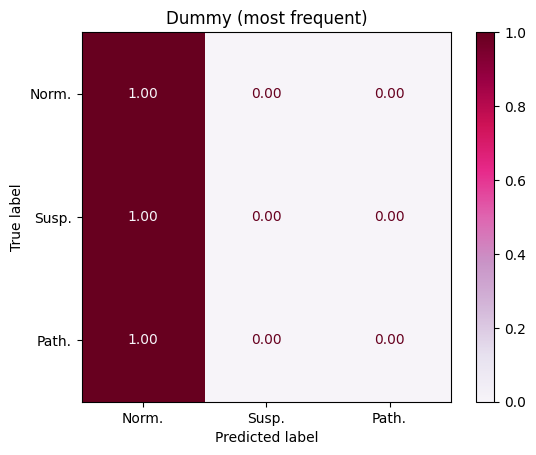


### Logistic regression ###
Logistic regression | CV f1_macro: 0.802 ± 0.024

=== Logistic regression ===
Accuracy:  0.885
Macro F1:  0.779

Classification report (zero_division=0):
              precision    recall  f1-score   support

         1.0       0.94      0.95      0.94       332
         2.0       0.61      0.68      0.64        59
         3.0       0.88      0.66      0.75        35

    accuracy                           0.88       426
   macro avg       0.81      0.76      0.78       426
weighted avg       0.89      0.88      0.89       426



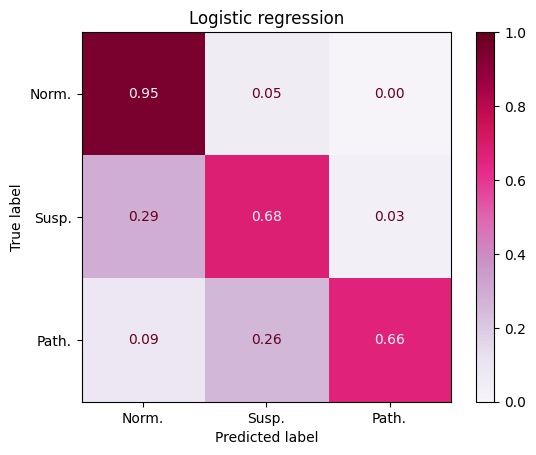


### Decision tree ###
Decision tree | CV f1_macro: 0.870 ± 0.033

=== Decision tree ===
Accuracy:  0.901
Macro F1:  0.816

Classification report (zero_division=0):
              precision    recall  f1-score   support

         1.0       0.94      0.95      0.95       332
         2.0       0.73      0.64      0.68        59
         3.0       0.81      0.83      0.82        35

    accuracy                           0.90       426
   macro avg       0.82      0.81      0.82       426
weighted avg       0.90      0.90      0.90       426



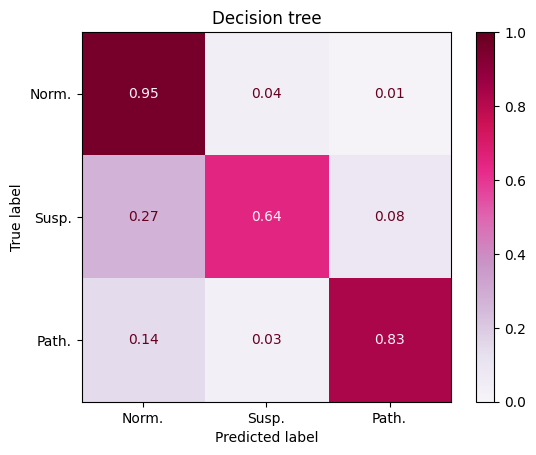

In [25]:
MODELS_BASELINE = {
    "Dummy (most frequent)": DummyClassifier(strategy="most_frequent"),
    "Logistic regression": Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        ]
    ),
    "Decision tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
}

results = {}

for name, clf in MODELS_BASELINE.items():
    print(f"\n### {name} ###")
    cross_val_scores_encoded(clf, X_train, y_train, model_name=name)
    fitted = evaluate_on_holdout_encoded(clf, X_train, y_train, X_test, y_test, le, model_name=name)
    results[name] = fitted

### Advanced model – HistGradientBoosting (tuned)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params (HGB): {'learning_rate': 0.2, 'max_depth': None, 'max_leaf_nodes': 31}
Best CV macro F1 (HGB): 0.9160157226283381

=== HistGradientBoosting (tuned) ===
Accuracy:  0.948
Macro F1:  0.905

Classification report (zero_division=0):
              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       332
         2.0       0.88      0.78      0.83        59
         3.0       0.91      0.91      0.91        35

    accuracy                           0.95       426
   macro avg       0.92      0.89      0.90       426
weighted avg       0.95      0.95      0.95       426



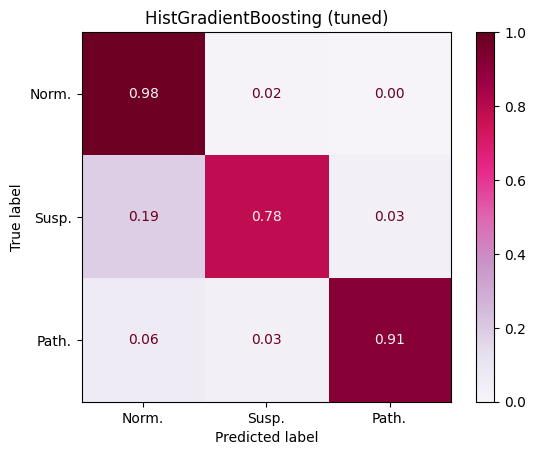

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params (HGB), rep.: {'learning_rate': 0.1, 'max_depth': 5, 'max_leaf_nodes': 31}
Best CV macro F1 (HGB), rep.: 0.914360438002406

=== HistGradientBoosting (tuned, rep.) ===
Accuracy:  0.939
Macro F1:  0.892

Classification report (zero_division=0):
              precision    recall  f1-score   support

         1.0       0.96      0.97      0.97       332
         2.0       0.83      0.76      0.80        59
         3.0       0.91      0.91      0.91        35

    accuracy                           0.94       426
   macro avg       0.90      0.88      0.89       426
weighted avg       0.94      0.94      0.94       426



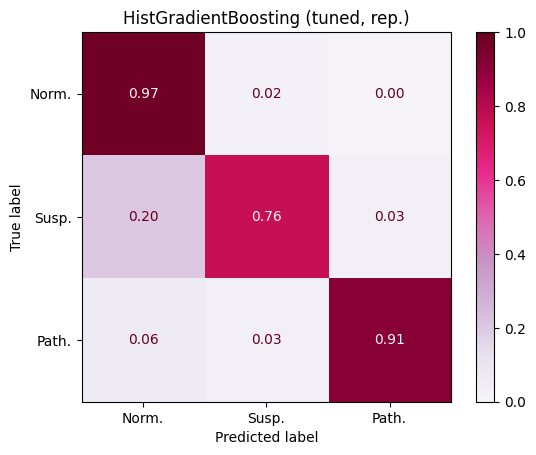

In [27]:
hgb = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE
)

hgb_param_grid = {
    "max_depth": [None, 3, 5],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_leaf_nodes": [31, 63],
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Using all the features

hgb_grid = GridSearchCV(
    estimator=hgb,
    param_grid=hgb_param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

hgb_grid.fit(X_train, y_train)

print("Best params (HGB):", hgb_grid.best_params_)
print("Best CV macro F1 (HGB):", hgb_grid.best_score_)

best_hgb = hgb_grid.best_estimator_

_ = evaluate_on_holdout_encoded(
    best_hgb,
    X_train,
    y_train,
    X_test,
    y_test,
    le,
    model_name="HistGradientBoosting (tuned)",
)

# Using only representative features

hgb_rep = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

hgb_rep_grid = GridSearchCV(
    estimator=hgb_rep,
    param_grid=hgb_param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

hgb_rep_grid.fit(X_train_rep, y_train_rep)
print("Best params (HGB), rep.:", hgb_rep_grid.best_params_)
print("Best CV macro F1 (HGB), rep.:", hgb_rep_grid.best_score_)

best_hgb_rep = hgb_rep_grid.best_estimator_
_ = evaluate_on_holdout_encoded(
    best_hgb_rep,
    X_train_rep,
    y_train_rep,
    X_test_rep,
    y_test_rep,
    le,
    model_name="HistGradientBoosting (tuned, rep.)",
)

### Advanced model – XGBoost (tuned)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params (XGB), rep.: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}
Best CV macro F1 (XGB), rep.: 0.9270978504450962

=== XGBoost (tuned) ===
Accuracy:  0.939
Macro F1:  0.890

Classification report (zero_division=0):
              precision    recall  f1-score   support

         1.0       0.95      0.98      0.97       332
         2.0       0.86      0.73      0.79        59
         3.0       0.91      0.91      0.91        35

    accuracy                           0.94       426
   macro avg       0.91      0.87      0.89       426
weighted avg       0.94      0.94      0.94       426



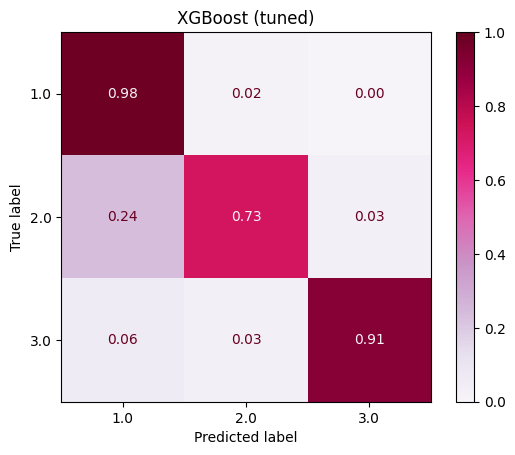

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best params (XGB, rep.): {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.8}
Best CV macro F1 (XGB, rep.): 0.9238851363021361

=== XGBoost (tuned, rep.) ===
Accuracy:  0.932
Macro F1:  0.866

Classification report (zero_division=0):
              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       332
         2.0       0.91      0.68      0.78        59
         3.0       0.86      0.86      0.86        35

    accuracy                           0.93       426
   macro avg       0.90      0.84      0.87       426
weighted avg       0.93      0.93      0.93       426



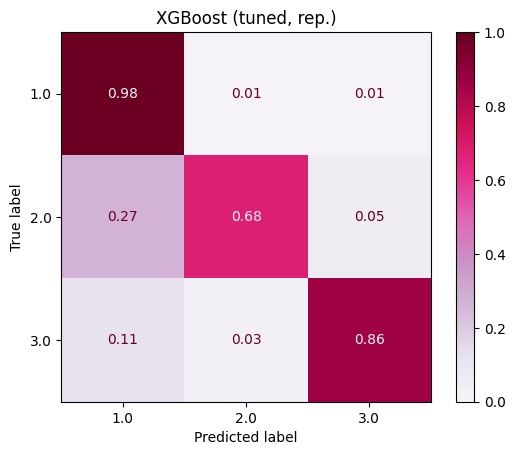

In [14]:
try:
    from xgboost import XGBClassifier
except ImportError:
    raise ImportError(
        "xgboost is not installed. Install it with `pip install xgboost` "
        "in your environment and rerun this cell."
    )

xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(class_labels),
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=RANDOM_STATE,
)

xgb_param_grid = {
    "n_estimators": [150, 250],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
}

xgb_cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Using all the features

xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    scoring="f1_macro",
    cv=xgb_cv,
    n_jobs=-1,
    verbose=1,
)

xgb_grid.fit(X_train, y_train)

print("Best params (XGB), rep.:", xgb_grid.best_params_)
print("Best CV macro F1 (XGB), rep.:", xgb_grid.best_score_)

best_xgb = xgb_grid.best_estimator_

_ = evaluate_on_holdout_encoded(
    best_xgb,
    X_train,
    y_train,
    X_test,
    y_test,
    le,
    model_name="XGBoost (tuned)",
)

# Using only representative features

xgb_rep_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    scoring="f1_macro",
    cv=xgb_cv,
    n_jobs=-1,
    verbose=1,
)

xgb_rep_grid.fit(X_train_rep, y_train_rep)

print("Best params (XGB, rep.):", xgb_rep_grid.best_params_)
print("Best CV macro F1 (XGB, rep.):", xgb_rep_grid.best_score_)

best_xgb_rep = xgb_rep_grid.best_estimator_

_ = evaluate_on_holdout_encoded(
    best_xgb_rep,
    X_train_rep,
    y_train_rep,
    X_test_rep,
    y_test_rep,
    le,
    model_name="XGBoost (tuned, rep.)",
)

### Best model selection for threshold tuning

In [15]:
final_model = best_hgb

In [16]:
def threshold_sweep_for_class(_m, _X, _y_enc, _le, _positive_label, _threshold=None):
    """
    Treat `positive_label` (original label, e.g. 3.0 for pathological)
    vs all other labels as a binary problem.

    For each threshold t on P(positive_label), compute:
      - recall for the positive class
      - precision for the positive class
      - F1 for the positive class
      - overall binary accuracy
      - FP and FN counts

    Returns a DataFrame with these columns.
    """
    if _threshold is None:
        _threshold = np.linspace(0.1, 0.9, 18)

    classes_orig = _le.classes_
    classes_enc = _m.classes_

    pos_enc = np.where(classes_orig == _positive_label)[0][0]
    pos_col = np.where(classes_enc == pos_enc)[0][0]

    proba = _m.predict_proba(_X)
    p_pos = proba[:, pos_col]

    # Binary ground truth: 1 if positive class, 0 otherwise
    y_true_bin = (_y_enc == pos_enc).astype(int)

    rows = []
    for t in _threshold:
        y_pred_bin = (p_pos >= t).astype(int)

        rec = recall_score(y_true_bin, y_pred_bin, zero_division=0)
        prec = precision_score(y_true_bin, y_pred_bin, zero_division=0)
        acc = accuracy_score(y_true_bin, y_pred_bin)

        fn = int(((y_true_bin == 1) & (y_pred_bin == 0)).sum())
        fp = int(((y_true_bin == 0) & (y_pred_bin == 1)).sum())

        f1 = 0.0
        if prec + rec > 0:
            f1 = 2 * prec * rec / (prec + rec)

        rows.append(
            {
                "threshold": t,
                "recall_pos": rec,
                "precision_pos": prec,
                "f1_pos": f1,
                "accuracy": acc,
                "false_negatives": fn,
                "false_positives": fp,
            }
        )

    return pd.DataFrame(rows)

### Threshold sweep for class 3 (pathological)

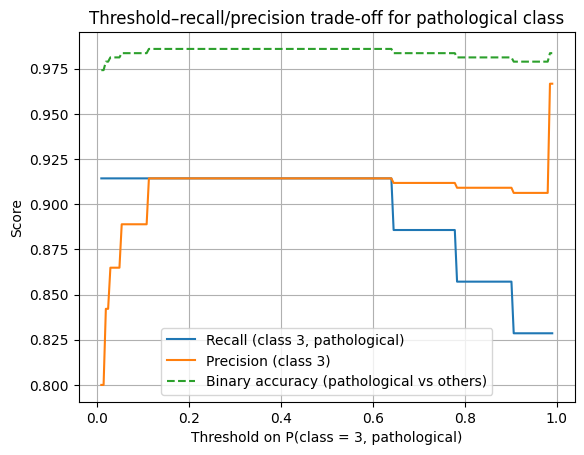

In [17]:
thresholds = np.linspace(0.01, 0.99, 200)

sweep_path = threshold_sweep_for_class(
    final_model,
    X_test,
    y_test,
    le,
    _positive_label=3.0,
    _threshold=thresholds,
)

plt.figure()
plt.plot(
    sweep_path["threshold"],
    sweep_path["recall_pos"],
    label="Recall (class 3, pathological)",
)
plt.plot(
    sweep_path["threshold"],
    sweep_path["precision_pos"],
    label="Precision (class 3)",
)
plt.plot(
    sweep_path["threshold"],
    sweep_path["accuracy"],
    label="Binary accuracy (pathological vs others)",
    linestyle="--",
)

plt.xlabel("Threshold on P(class = 3, pathological)")
plt.ylabel("Score")
plt.title("Threshold–recall/precision trade-off for pathological class")
plt.legend()
plt.grid(True)
plt.show()

### Threshold sweep for class 2 (suspect)

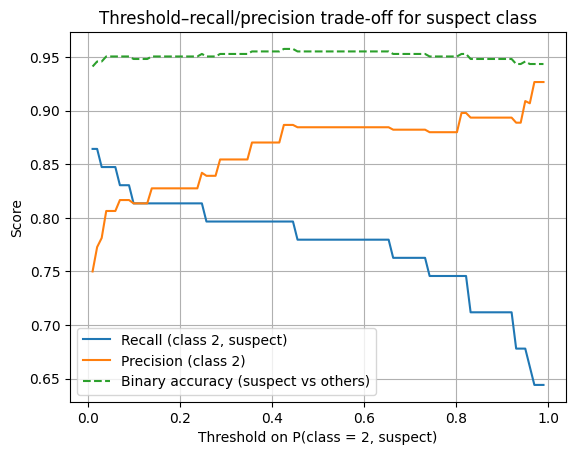

In [18]:
thresholds = np.linspace(0.01, 0.99, 100)

sweep_suspect = threshold_sweep_for_class(
    final_model,
    X_test,
    y_test,
    le,
    _positive_label=2.0,
    _threshold=thresholds,
)

plt.figure()
plt.plot(
    sweep_suspect["threshold"],
    sweep_suspect["recall_pos"],
    label="Recall (class 2, suspect)",
)
plt.plot(
    sweep_suspect["threshold"],
    sweep_suspect["precision_pos"],
    label="Precision (class 2)",
)
plt.plot(
    sweep_suspect["threshold"],
    sweep_suspect["accuracy"],
    label="Binary accuracy (suspect vs others)",
    linestyle="--",
)

plt.xlabel("Threshold on P(class = 2, suspect)")
plt.ylabel("Score")
plt.title("Threshold–recall/precision trade-off for suspect class")
plt.legend()
plt.grid(True)
plt.show()


### Hierarchical decision rule and evaluation

In [19]:
def _orig_to_proba_col_map(_m, _le):
    """
    Build mapping: original label (1., 2., 3.) -> column index in predict_proba.
    """
    classes_orig = _le.classes_
    classes_enc = _m.classes_

    mapping = {}
    for orig in classes_orig:
        enc = np.where(classes_orig == orig)[0][0]
        col = np.where(classes_enc == enc)[0][0]
        mapping[int(orig)] = col
    return mapping


def predict_hierarchical_path_then_suspect(_m, _X, _le, _t_path=0.4, _t_suspect=0.4):
    """
    Hierarchical rule:
      1) if P(pathological, class 3) >= t_path    -> predict 3
      2) elif P(suspect, class 2)    >= t_suspect -> predict 2
      3) else                                     -> predict 1 (normal)
    """
    col_map = _orig_to_proba_col_map(_m, _le)
    col1 = col_map[1]
    col2 = col_map[2]
    col3 = col_map[3]

    proba = _m.predict_proba(_X)
    preds = np.empty(len(_X))

    for i, p in enumerate(proba):
        if p[col3] >= _t_path:
            preds[i] = 3.0
        elif p[col2] >= _t_suspect:
            preds[i] = 2.0
        else:
            preds[i] = 1.0

    return preds


def predict_hierarchical_suspect_then_path(_m, _X, _le, _t_suspect=0.4, _t_path=0.4):
    """
    Alternative rule:
      1) if P(suspect, class 2)   >= t_suspect -> predict 2
      2) elif P(pathological, 3)  >= t_path    -> predict 3
      3) else                                  -> predict 1
    """
    col_map = _orig_to_proba_col_map(_m, _le)
    col1 = col_map[1]
    col2 = col_map[2]
    col3 = col_map[3]

    proba = _m.predict_proba(_X)
    preds = np.empty(len(_X))

    for i, p in enumerate(proba):
        if p[col2] >= _t_suspect:
            preds[i] = 2.0
        elif p[col3] >= _t_path:
            preds[i] = 3.0
        else:
            preds[i] = 1.0

    return preds

In [20]:
def evaluate_hierarchical(_m, _X, _y_enc, _le, _pred_fn, _name, **pred_kwargs):
    """
    Apply a hierarchical prediction rule (pred_fn) and print:
      - accuracy
      - macro F1
      - per-class recall
      - under/over-estimation counts
      - confusion matrix + classification report
    """
    y_true = _le.inverse_transform(_y_enc)
    y_pred = _pred_fn(_m, _X, _le, **pred_kwargs)

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    recs = recall_score(y_true, y_pred, labels=_le.classes_, average=None, zero_division=0)

    print(f"Accuracy: {acc:.3f}")
    print(f"Macro F1: {macro_f1:.3f}\n")
    for label, rec in zip(_le.classes_, recs):
        print(f"Recall class {int(label)}: {rec:.3f}")

    cm = confusion_matrix(y_true, y_pred, labels=_le.classes_, normalize="true")
    print("\nConfusion matrix (rows=true, cols=pred):")
    print(cm)

    under_errors = np.tril(cm, k=-1).sum()   # below diagonal
    over_errors = np.triu(cm, k=1).sum()     # above diagonal
    print(f"\nUnder-estimation errors (below diagonal): {under_errors}")
    print(f"Over-estimation errors (above diagonal):  {over_errors}\n")

    print("Classification report (hierarchical predictions):")
    print(classification_report(y_true, y_pred, zero_division=0))

    disp = ConfusionMatrixDisplay(cm, display_labels=get_pretty_labels(_le))
    disp.plot(cmap="PuRd", values_format=".2f", im_kw={'norm': matplotlib.colors.Normalize(vmin=0, vmax=1)})
    plt.title(f"Confusion matrix – {_name}")
    plt.show()

### Choosing thresholds for evaluation

=== Path then suspect ===
Accuracy: 0.927
Macro F1: 0.887

Recall class 1: 0.934
Recall class 2: 0.898
Recall class 3: 0.914

Confusion matrix (rows=true, cols=pred):
[[0.93373494 0.06325301 0.00301205]
 [0.06779661 0.89830508 0.03389831]
 [0.05714286 0.02857143 0.91428571]]

Under-estimation errors (below diagonal): 0.15351089588377725
Over-estimation errors (above diagonal):  0.1001633653257096

Classification report (hierarchical predictions):
              precision    recall  f1-score   support

         1.0       0.98      0.93      0.96       332
         2.0       0.71      0.90      0.79        59
         3.0       0.91      0.91      0.91        35

    accuracy                           0.93       426
   macro avg       0.87      0.92      0.89       426
weighted avg       0.94      0.93      0.93       426



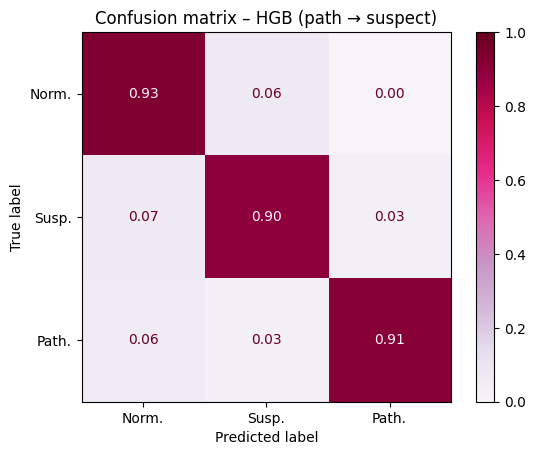



=== Suspect then path ===
Accuracy: 0.920
Macro F1: 0.865

Recall class 1: 0.934
Recall class 2: 0.898
Recall class 3: 0.829

Confusion matrix (rows=true, cols=pred):
[[0.93373494 0.06325301 0.00301205]
 [0.06779661 0.89830508 0.03389831]
 [0.05714286 0.11428571 0.82857143]]

Under-estimation errors (below diagonal): 0.23922518159806294
Over-estimation errors (above diagonal):  0.1001633653257096

Classification report (hierarchical predictions):
              precision    recall  f1-score   support

         1.0       0.98      0.93      0.96       332
         2.0       0.68      0.90      0.77        59
         3.0       0.91      0.83      0.87        35

    accuracy                           0.92       426
   macro avg       0.86      0.89      0.87       426
weighted avg       0.93      0.92      0.92       426



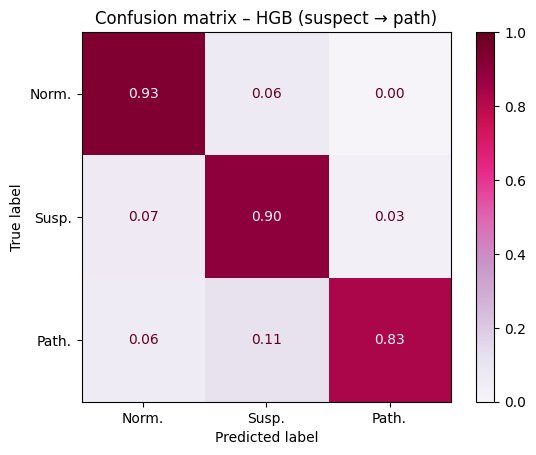

In [21]:
t_path = 0.5
t_suspect = 0.002

print("=== Path then suspect ===")
evaluate_hierarchical(
    final_model,
    X_test,
    y_test,
    le,
    _pred_fn=predict_hierarchical_path_then_suspect,
    _t_path=t_path,
    _t_suspect=t_suspect,
    _name="HGB (path → suspect)"
)

print("\n\n=== Suspect then path ===")
evaluate_hierarchical(
    final_model,
    X_test,
    y_test,
    le,
    _pred_fn=predict_hierarchical_suspect_then_path,
    _t_path=t_path,
    _t_suspect=t_suspect,
    _name="HGB (suspect → path)"
)